In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from EvGym import config

In [2]:
save = False
#df_imb_pre = pd.read_csv("./data/imbalance_prices_2019.csv", parse_dates=["Date"])
df_imb_pre = pd.read_csv('./data/tennet/settlementprices_history.csv', parse_dates=["Date"])
df_imb_pre.head()

/tmp/ipykernel_111384/2417576473.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_imb_pre = pd.read_csv('./data/tennet/settlementprices_history.csv', parse_dates=["Date"])


,Date,PTE,period_from,period_until,upward_incident_reserve,downward_incident_reserve,To regulate up,To regulate down,Incentive component,Consume,Feed,Regulation state
0,2014-01-01,1,00:00,00:15,NaN,NaN,NaN,7.40,0,7.40,7.40,-1
1,2014-01-01,2,00:15,00:30,NaN,NaN,NaN,14.46,0,14.46,14.46,-1
2,2014-01-01,3,00:30,00:45,NaN,NaN,NaN,15.40,0,15.40,15.40,-1
3,2014-01-01,4,00:45,01:00,NaN,NaN,NaN,-43.01,0,-43.01,-43.01,-1
4,2014-01-01,5,01:00,01:15,NaN,NaN,NaN,20.18,0,20.18,20.18,-1


In [3]:
df_imb_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210336 entries, 0 to 210335
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       210336 non-null  datetime64[ns]
 1   PTE                        210336 non-null  int64         
 2   period_from                210336 non-null  object        
 3   period_until               210336 non-null  object        
 4   upward_incident_reserve    812 non-null     object        
 5   downward_incident_reserve  11 non-null      object        
 6   To regulate up             115664 non-null  float64       
 7   To regulate down           120435 non-null  float64       
 8   Incentive component        210336 non-null  int64         
 9   Consume                    210336 non-null  float64       
 10  Feed                       210336 non-null  float64       
 11  Regulation state           210336 non-null  int64   

In [4]:
df_imb_pre["datetime"] = df_imb_pre["Date"] + pd.to_timedelta(df_imb_pre["period_from"]+':00')
df_imb_pre["datehour"] = df_imb_pre["datetime"].dt.strftime("%Y-%m-%d %H:00:00")
df_imb_pre["ts_cte"] = (df_imb_pre["datetime"] - config.starttime_min).dt.total_seconds() / config.timestep
df_imb_pre = df_imb_pre.sort_values(by="datetime").reset_index(drop=True)
df_imb_pre["price_da"] = 0
df_imb_pre["feed"] = df_imb_pre["Feed"] / 1000
df_imb_pre["consume"] = df_imb_pre["Consume"] / 1000

In [5]:
df_imb_pre[["datetime", "datehour", "ts_cte", "Date", "consume", "feed"]].describe()

,datetime,ts_cte,Date,consume,feed
count,210336,210336.000000,210336,210336.000000,210336.000000
mean,2016-12-31 12:27:34.792332544,149028.459665,2016-12-31 00:35:04.792332288,0.043585,0.039840
min,2014-01-01 00:00:00,122736.000000,2014-01-01 00:00:00,-0.500000,-0.500000
25%,2015-07-02 18:56:15,135882.937500,2015-07-02 00:00:00,0.025820,0.024690
50%,2016-12-31 11:52:30,149027.875000,2016-12-31 00:00:00,0.034175,0.032710
75%,2018-07-02 06:48:45,162174.812500,2018-07-02 00:00:00,0.045890,0.043390
max,2019-12-31 23:45:00,175319.750000,2019-12-31 00:00:00,0.936120,0.936120
std,NaN,15179.741843,NaN,0.059441,0.057332


In [6]:
def make_point(df_imb_pre, imb_col):
    df_imb = df_imb_pre[df_imb_pre["datetime"].dt.minute == 0].copy()
    df_imb = df_imb.rename(columns={imb_col: "price_im", "datetime": "date"}).reset_index(drop=True)
    df_imb = df_imb.sort_values(by="date").reset_index(drop=True)
    df_imb["ts"] = df_imb.index + df_imb["ts_cte"].min()
    df_imb = df_imb[["date", "price_da", "price_im", "ts"]]
    return df_imb

def make_average(df_imb_pre, imb_col):
    df_imb = df_imb_pre.groupby(by="datehour").agg(
                                                    price_da = ('price_da', 'mean'),
                                                    price_im = (imb_col, 'mean'),
                                                    ts_cte = ('ts_cte', 'min'),
                                                     ).reset_index()

    df_imb = df_imb.rename(columns={imb_col: "price_im", "datehour": "date"}).reset_index(drop=True)
    df_imb = df_imb.sort_values(by="date").reset_index(drop=True)
    df_imb["ts"] = df_imb.index + df_imb["ts_cte"].min()
    df_imb = df_imb[["date", "price_da", "price_im", "ts"]]
    return df_imb

In [7]:
# Make 4 prices
quant = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.85, 0.9, 0.99, 1]
# 1. Feed when minutes == 0
df_imb_a = make_point(df_imb_pre, "feed")
print("a----\n", len(df_imb_a), df_imb_a["price_im"].quantile(quant))

# 2. Feed averaged over the hour
df_imb_b = make_average(df_imb_pre, "feed")
print("b----\n", len(df_imb_b), df_imb_b["price_im"].quantile(quant))

# 3. Consume when minutes == 0
df_imb_c = make_point(df_imb_pre, "consume")
print("c----\n", len(df_imb_c), df_imb_c["price_im"].quantile(quant))

# 4. Consume averaged over the hour
df_imb_d = make_average(df_imb_pre, "consume")
print("d----\n", len(df_imb_d), df_imb_d["price_im"].quantile(quant))
# Columns: date (datetime), price_da (all zeros), price_im, ts
# Also a version without outliers

a----
 52584 0.00   -0.500000
0.01   -0.150097
0.10    0.005780
0.25    0.023137
0.50    0.032190
0.75    0.044860
0.85    0.060020
0.90    0.097937
0.99    0.350020
1.00    0.764920
Name: price_im, dtype: float64
b----
 52578 0.00   -0.434200
0.01   -0.060303
0.10    0.010663
0.25    0.024588
0.50    0.033865
0.75    0.047616
0.85    0.063971
0.90    0.080064
0.99    0.190597
1.00    0.590907
Name: price_im, dtype: float64
c----
 52584 0.00   -0.500000
0.01   -0.150030
0.10    0.013073
0.25    0.025830
0.50    0.035440
0.75    0.050463
0.85    0.070875
0.90    0.122091
0.99    0.350030
1.00    0.906670
Name: price_im, dtype: float64
d----
 52578 0.00   -0.434200
0.01   -0.053186
0.10    0.014678
0.25    0.026238
0.50    0.035733
0.75    0.050989
0.85    0.070320
0.90    0.087126
0.99    0.201405
1.00    0.590907
Name: price_im, dtype: float64


In [8]:
df_imb_a_2019 = df_imb_a[df_imb_a["date"].dt.year == 2019]
df_imb_c_2019 = df_imb_c[df_imb_c["date"].dt.year == 2019]

print("a_2019----\n", len(df_imb_a_2019), df_imb_a_2019["price_im"].quantile(quant))
print("c_2019----\n", len(df_imb_c_2019), df_imb_c_2019["price_im"].quantile(quant))

a_2019----
 8760 0.00   -0.487650
0.01   -0.135912
0.10    0.011448
0.25    0.022828
0.50    0.030770
0.75    0.042700
0.85    0.060120
0.90    0.102079
0.99    0.263829
1.00    0.764920
Name: price_im, dtype: float64
c_2019----
 8760 0.00   -0.487650
0.01   -0.122787
0.10    0.015860
0.25    0.025898
0.50    0.033470
0.75    0.046993
0.85    0.065696
0.90    0.116124
0.99    0.268093
1.00    0.764920
Name: price_im, dtype: float64


In [9]:
# Save a, b, c, d, as, bs, cs, ds
if save:
    df_imb_a.to_csv("./data/df_prices_a.csv", index=False)
    df_imb_c.to_csv("./data/df_prices_c.csv", index=False)
    df_imb_a_2019.to_csv("./data/df_prices_2019_a.csv", index=False)
    df_imb_c_2019.to_csv("./data/df_prices_2019_c.csv", index=False)
    #df_imb_d.to_csv("./data/df_prices_2019_d.csv", index=False)
    #df_imb_as.to_csv("./data/df_prices_2019_as.csv", index=False)
    #df_imb_bs.to_csv("./data/df_prices_2019_bs.csv", index=False)
    #df_imb_cs.to_csv("./data/df_prices_2019_cs.csv", index=False)
    #df_imb_ds.to_csv("./data/df_prices_2019_ds.csv", index=False)

In [10]:
display(df_imb_a.describe())
display(df_imb_c.describe())
display(df_imb_a_2019.describe())
display(df_imb_c_2019.describe())

,date,price_da,price_im,ts
count,52584,52584.0,52584.000000,52584.000000
mean,2016-12-31 12:05:04.792332288,0.0,0.041263,149027.500000
min,2014-01-01 00:00:00,0.0,-0.500000,122736.000000
25%,2015-07-02 18:45:00,0.0,0.023137,135881.750000
50%,2016-12-31 11:30:00,0.0,0.032190,149027.500000
75%,2018-07-02 06:15:00,0.0,0.044860,162173.250000
max,2019-12-31 23:00:00,0.0,0.764920,175319.000000
std,NaN,0.0,0.068404,15179.837614


,date,price_da,price_im,ts
count,52584,52584.0,52584.000000,52584.000000
mean,2016-12-31 12:05:04.792332288,0.0,0.048383,149027.500000
min,2014-01-01 00:00:00,0.0,-0.500000,122736.000000
25%,2015-07-02 18:45:00,0.0,0.025830,135881.750000
50%,2016-12-31 11:30:00,0.0,0.035440,149027.500000
75%,2018-07-02 06:15:00,0.0,0.050463,162173.250000
max,2019-12-31 23:00:00,0.0,0.906670,175319.000000
std,NaN,0.0,0.070710,15179.837614


,date,price_da,price_im,ts
count,8760,8760.0,8760.000000,8760.000000
mean,2019-07-02 12:04:31.232876800,0.0,0.042307,170939.500000
min,2019-01-01 00:00:00,0.0,-0.487650,166560.000000
25%,2019-04-02 06:45:00,0.0,0.022828,168749.750000
50%,2019-07-02 12:30:00,0.0,0.030770,170939.500000
75%,2019-10-01 18:15:00,0.0,0.042700,173129.250000
max,2019-12-31 23:00:00,0.0,0.764920,175319.000000
std,NaN,0.0,0.061666,2528.938512


,date,price_da,price_im,ts
count,8760,8760.0,8760.000000,8760.000000
mean,2019-07-02 12:04:31.232876800,0.0,0.047665,170939.500000
min,2019-01-01 00:00:00,0.0,-0.487650,166560.000000
25%,2019-04-02 06:45:00,0.0,0.025898,168749.750000
50%,2019-07-02 12:30:00,0.0,0.033470,170939.500000
75%,2019-10-01 18:15:00,0.0,0.046993,173129.250000
max,2019-12-31 23:00:00,0.0,0.764920,175319.000000
std,NaN,0.0,0.062293,2528.938512


In [11]:
df_imb_a[df_imb_a["ts"] == 168698]

,date,price_da,price_im,ts
45962,2019-03-31 03:00:00,0,0.01585,168698.0


In [12]:
def smooth(x):
    median = x.median()
    iqr = x.quantile(0.75) - x.quantile(0.25)
    y = np.tanh((x - median) / (2*iqr)) * 2*iqr + median
    return y

In [13]:
df_imb_as = df_imb_a.copy()
df_imb_as["price_im"] = smooth(df_imb_as["price_im"])
df_imb_bs = df_imb_b.copy()
df_imb_bs["price_im"] = smooth(df_imb_bs["price_im"])
df_imb_cs = df_imb_c.copy()
df_imb_cs["price_im"] = smooth(df_imb_cs["price_im"])
df_imb_ds = df_imb_d.copy()
df_imb_ds["price_im"] = smooth(df_imb_ds["price_im"])

## EDA

count    744.000000
mean       0.064788
std        0.069901
min       -0.150030
25%        0.041597
50%        0.047910
75%        0.066880
max        0.565580
Name: price_im, dtype: float64

iqr_1: 0.0252825


{'whiskers': [<matplotlib.lines.Line2D at 0x7f8e1ded1820>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8e1ded1c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8e1df197f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f8e1de651c0>,
 'fliers': [],
 'means': []}

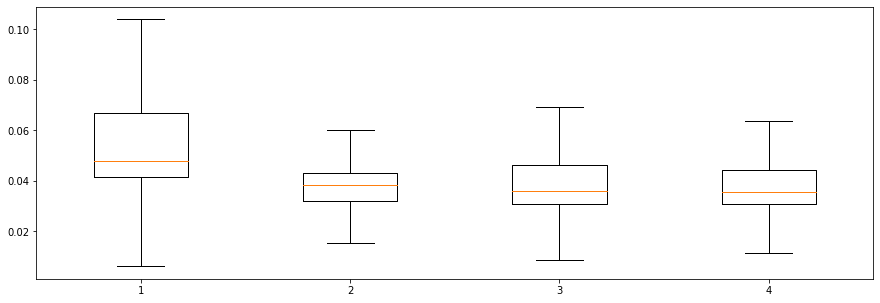

In [27]:
price_1 = df_imb_c[(df_imb_c["date"].dt.year == 2019) & (df_imb_c["date"].dt.month == 1)]["price_im"]
price_2 = df_imb_c[(df_imb_c["date"].dt.year == 2019) & (df_imb_c["date"].dt.month == 2)]["price_im"]
price_3 = df_imb_c[(df_imb_c["date"].dt.year == 2019) & (df_imb_c["date"].dt.month == 3)]["price_im"]
price_4 = df_imb_c[(df_imb_c["date"].dt.year == 2019) & (df_imb_c["date"].dt.month == 4)]["price_im"]

display(price_1.describe())
iqr_1 = price_1.quantile(0.75) - price_1.quantile(0.25)
print("iqr_1:", iqr_1)

fig1, ax1 = plt.subplots(figsize=(15, 5)) 
ax1.boxplot([price_1, price_2, price_3, price_4], showfliers=False)